### Needed Libraries

In [1]:
#for data visualization
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#stop_words = set(stopwords.words("german"))
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

# Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

#for model-building
from sklearn.model_selection import train_test_split

#to save the model
import joblib
import pickle

#CrossValidation
from sklearn.model_selection import StratifiedKFold

#Classifiers
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

#for Metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

#for Arrays
import numpy as np

#for REST API
from flask import Flask
import flask.scaffold
flask.helpers._endpoint_from_view_func = flask.scaffold._endpoint_from_view_func
from flask_restful import Resource, Api, reqparse

### Read and visualize the dataset

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Panorama'),
  Text(1, 0, 'Web'),
  Text(2, 0, 'International'),
  Text(3, 0, 'Wirtschaft'),
  Text(4, 0, 'Sport'),
  Text(5, 0, 'Inland'),
  Text(6, 0, 'Etat'),
  Text(7, 0, 'Wissenschaft'),
  Text(8, 0, 'Kultur')])

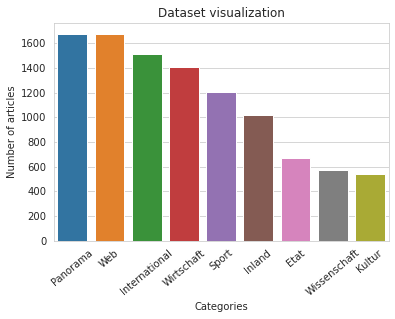

In [2]:
dataset='10kGNAD.csv'
df = pd.read_csv(dataset, sep=';', header=None, usecols=[0,1], names=['category', 'text'])
x=df['category'].value_counts()
sns.barplot(x.index,x).set(title='Dataset visualization', xlabel='Categories', ylabel='Number of articles')
plt.xticks(rotation=40)

### Text Classification

In [3]:
def classification(vect, cl):
    #feature extraction
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    #evaluating the classifier results
    cl.fit(X_train_dtm, Y_train)
    Y_pred_class = cl.predict(X_test_dtm)
    #y_prob = cl.predict_proba(X_test_dtm)[:,1]
    print(classification_report(Y_test,Y_pred_class))
    print('Confusion Matrix:',confusion_matrix(Y_test, Y_pred_class))

In [4]:
#for lemmatization
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [ ]:
#define variables
optionL='german'
metrics = []
vectorizer='TF-IDF'
classifier='SVM'
validation='20Test'
X, Y = df['text'], df['category']

#the list of stop_words for the corresponding language
stop_words = stopwords.words(optionL.lower())

#pre-processing (remove punctuations, lower(), stop_words removal, lemmatization, bag of words)
if vectorizer=='TF-IDF':
    vect = TfidfVectorizer(use_idf=True, tokenizer=LemmaTokenizer(), strip_accents = 'unicode', ngram_range=(1,2), stop_words=stop_words)
else:
    vect = CountVectorizer(use_idf=True, tokenizer=LemmaTokenizer(), strip_accents = 'unicode', ngram_range=(1,2) , stop_words=stop_words)

#Choose a classifier
if classifier=='SVM':
    cl = SVC() 
else:
    cl = MultinomialNB()

#choose a method for the training/test
if validation=='Cross-Validation':
    #20-fold cross_validation
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        classification(vect, cl)
else:
    #Split the dataset: train & test
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,shuffle=True)
    #classification and evaluation
    classification(vect, cl)

### Save the model

In [11]:
clModel = open("clModel.pkl","wb")
joblib.dump(cl,clModel)
clModel.close()

### Save the vectorizer

In [12]:
tfidfVec = open("tfidfVec.pkl","wb")
joblib.dump(vect,tfidfVec)
tfidfVec.close()

### Load the saved model and vectorizer to classify new texts

In [3]:
text="Die ARD-Tochter Degeto hat sich verpflichtet, ab August einer Quotenregelung zu folgen, die für die Gleichstellung von Regisseurinnen sorgen soll. In mindestens 20 Prozent der Filme, die die ARD-Tochter Degeto produziert oder mitfinanziert, sollen ab Mitte August Frauen Regie führen. Degeto-Chefin Christine Strobl folgt mit dieser Selbstverpflichtung der Forderung von Pro Quote Regie. Die Vereinigung von Regisseurinnen hatte im vergangenen Jahr eine Quotenregelung gefordert, um den weiblichen Filmschaffenden mehr Gehör und ökonomische Gleichstellung zu verschaffen. Pro Quote Regie kritisiert, dass, während rund 50 Prozent der Regie-Studierenden weiblich seien, der Anteil der Regisseurinnen bei Fernsehfilmen nur bei 13 bis 15 Prozent liege. In Österreich sieht die Situation ähnlich aus, auch hier wird von unterschiedlichen Seiten Handlungsbedarf angemahnt. Aber wie soll dieser aussehen? Ist die Einführung der Quotenregelung auch für die österreichische Film- und Fernsehlandschaft sinnvoll? Diskutieren Sie im Forum."
#load the model from disk
model = open("model/clModel.pkl","rb")
loaded_model = joblib.load(model)
#load the vectorizer from disk
vec = open("model/tfidfVec.pkl","rb")
loaded_vec = joblib.load(vec)
#predict the class for the given text
y_pred_class = loaded_model.predict(loaded_vec.transform([text]))
print("the predicted class is:", y_pred_class[0])

the predicted class is: Etat


### Deploy the model as a REST API

In [4]:
from flask import Flask
from gevent.pywsgi import WSGIServer

app = Flask(__name__)
api = Api(app)

#You can test with this query: "text="Die ARD-Tochter Degeto hat sich verpflichtet, ab August einer Quotenregelung zu folgen, die für die Gleichstellung von Regisseurinnen sorgen soll. In mindestens 20 Prozent der Filme, die die ARD-Tochter Degeto produziert oder mitfinanziert, sollen ab Mitte August Frauen Regie führen. Degeto-Chefin Christine Strobl folgt mit dieser Selbstverpflichtung der Forderung von Pro Quote Regie. Die Vereinigung von Regisseurinnen hatte im vergangenen Jahr eine Quotenregelung gefordert, um den weiblichen Filmschaffenden mehr Gehör und ökonomische Gleichstellung zu verschaffen. Pro Quote Regie kritisiert, dass, während rund 50 Prozent der Regie-Studierenden weiblich seien, der Anteil der Regisseurinnen bei Fernsehfilmen nur bei 13 bis 15 Prozent liege. In Österreich sieht die Situation ähnlich aus, auch hier wird von unterschiedlichen Seiten Handlungsbedarf angemahnt. Aber wie soll dieser aussehen? Ist die Einführung der Quotenregelung auch für die österreichische Film- und Fernsehlandschaft sinnvoll? Diskutieren Sie im Forum.", it's taken from 10kGNAD dataset

# argument parsing
parser = reqparse.RequestParser()
parser.add_argument('query')

@app.route('/predictClass', methods=['GET'])
def index():
    # use parser and find the user's query
    args = parser.parse_args()
    user_query = args['query']        
    # vectorize the user's query and make a prediction
    uq_vectorized = loaded_vec.transform(np.array([user_query]))
    prediction = loaded_model.predict(uq_vectorized)
    
    return ('The predicted class for your query is: '+ prediction[0])

if __name__ == '__main__':
    # Debug/Development
    # app.run(debug=True, host="0.0.0.0", port="5000")
    # Production
    http_server = WSGIServer(('', 5000), app)
    http_server.serve_forever()

::ffff:127.0.0.1 - - [2021-11-17 00:19:35] "GET /predictClass?query=Die%20ARD-Tochter%20Degeto%20hat%20sich%20verpflichtet,%20ab%20August%20einer%20Quotenregelung%20zu%20folgen,%20die%20f%C3%BCr%20die%20Gleichstellung%20von%20Regisseurinnen%20sorgen%20soll.%20In%20mindestens%2020%20Prozent%20der%20Filme,%20die%20die%20ARD-Tochter%20Degeto%20produziert%20oder%20mitfinanziert,%20sollen%20ab%20Mitte%20August%20Frauen%20Regie%20f%C3%BChren.%20Degeto-Chefin%20Christine%20Strobl%20folgt%20mit%20dieser%20Selbstverpflichtung%20der%20Forderung%20von%20Pro%20Quote%20Regie.%20Die%20Vereinigung%20von%20Regisseurinnen%20hatte%20im%20vergangenen%20Jahr%20eine%20Quotenregelung%20gefordert,%20um%20den%20weiblichen%20Filmschaffenden%20mehr%20Geh%C3%B6r%20und%20%C3%B6konomische%20Gleichstellung%20zu%20verschaffen.%20Pro%20Quote%20Regie%20kritisiert,%20dass,%20w%C3%A4hrend%20rund%2050%20Prozent%20der%20Regie-Studierenden%20weiblich%20seien,%20der%20Anteil%20der%20Regisseurinnen%20bei%20Fernsehfilmen%20nu

::ffff:127.0.0.1 - - [2021-11-17 00:23:54] "GET /predictClass?query=Youtuber%20The%20iBookGuy%20erkl%C3%A4rt,%20wie%20farbenfrohe%20Games%20mit%20nur%2016k%20Speicher%20m%C3%B6glich%20waren.%20Moderne%20Videospiele%20sind%20wahnsinnig%20Hardware-hungrig.%20Hochaufl%C3%B6sende%20Grafiken%20ben%C3%B6tigen%20in%20einigen%20F%C3%A4llen%20bereits%20Gigabyte%20an%20dediziertem%20Videospeicher.%20Nach%20heutigen%20Ma%C3%9Fst%C3%A4ben%20ist%20es%20fast%20unvorstellbar,%20dass%20Computer%20und%20Spielkonsolen%20in%20den%20fr%C3%BChen%201980er-Jahren%20in%20der%20Regel%20lediglich%20%C3%BCber%20Arbeitsspeicher%20mit%2016%20Kilobyte,%2032k%20oder%20maximal%2064k%20verf%C3%BCgten.%20Und%20dennoch%20galt%20die%20Zeit%20als%20Goldene%20%C3%84ra%20der%20Games%20mit%20zahlreichen%20gro%C3%9Fen%20und%20bunten%20Klassikern.%20Wie%20das%20Angesichts%20dieser%20enormen%20Limitierungen%20%C3%BCberhaupt%20m%C3%B6glich%20war,%20erkl%C3%A4rt%20auf%20sehr%20anschauliche%20Weise%20ein%20neues%20Video%20des%20Yo

KeyboardInterrupt: 